# Spectral analysis - three clusters 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.cluster import SpectralClustering 
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix, csgraph
import pickle
import h5py
from skimage.measure import block_reduce
import pandas as pd
import random
from copy import deepcopy

from scipy import sparse
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh, lobpcg
from scipy.sparse.csgraph import connected_components

from matplotlib import offsetbox

import sys
sys.path.insert(0,"/analysis/ritter/AD/Budding_Spectral_Analysis/code/nitorch/")
from nitorch.data import load_nifti

import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy
%matplotlib inline

In [2]:
save_fig = True

In [3]:
# Get a list of RIDs for visualisation later 
data = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_holdout.csv', delimiter = ',')
participant_data = pd.read_csv('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ROSTER.csv', delimiter = ',')
participant_data = participant_data.rename(columns = {'PTID':'SubjectID'})
data= pd.merge(data, participant_data[['RID', 'SubjectID']], how = 'left').drop_duplicates()
subject_IDs = list(data['RID'])

In [4]:
# Load the heatmaps for the desired cases (comment in cases that are needed)

with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/LRP_heatmaps_AD.pkl', 'rb') as f:
    data_AD = pickle.load(f)
    
with open('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/LRP_heatmaps_HC.pkl', 'rb') as f:
    data_HC = pickle.load(f)
    
mean_maps_AD = load_nifti('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/LRP_AD.nii')

In [5]:
def min_max_normalization(subset):
    """Normalizes the data by subtracting the minimum and dividing by the maximum"""
    for i in range(len(subset)):
        subset[i] -= np.min(subset[i])
        subset[i] /= np.max(subset[i])
    return subset
    
def load_data(holdout_h5, dtype=np.float32):
    """ Load hdf5 files and extract columns. """
    X_train, y_train, X_val, y_val, X_holdout, y_holdout = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    holdout_h5_ = h5py.File(holdout_h5, 'r')
    X_holdout, y_holdout = holdout_h5_['X'], holdout_h5_['y']
    X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 1)
    X_holdout = min_max_normalization(X_holdout)
    y_holdout = np.array(y_holdout)
    print("Total test set length: {}".format(len(y_holdout)))
   
    return X_holdout, y_holdout

In [6]:
# Load holdout data 
X_holdout, y_holdout = load_data('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_holdout_no_outliers.h5')

Total test set length: 184


In [7]:
# Define cases and get indices and images, create data and labels 
cases = ['AD', 'HC']

indices_AD = [i[0] for i in data_AD]
images_AD = np.array([i[1] for i in data_AD])
indices_HC = [i[0] for i in data_HC]
images_HC = np.array([i[1] for i in data_HC])

images = np.concatenate((images_AD, images_HC))
labels = np.concatenate((np.zeros(len(indices_AD)), np.ones(len(images_HC))))
indices = np.concatenate((indices_AD, indices_HC))

In [8]:
# Sort images according to the original data set 
indices_sorted = [int(np.where(indices == i)[0]) for i in range(len(indices))]
images_sorted = images[indices_sorted]
labels = labels[indices_sorted]
images = images_sorted

In [9]:
# Get a list of subject IDs
subject_IDs = [subject_IDs[i] for i in indices]

In [10]:
# Create labels and masks for the two groups 
labels_classifier = ['AD' if i in indices_AD else 'HC' for i in range(len(data))]
mask_AD = [labels_classifier[i] == 'AD' for i in range(len(data))]
mask_HC = [labels_classifier[i] == 'HC' for i in range(len(data))]

In [11]:
# Flatten data such that it can be used as input for SpRay algorithm 
data_flattened = []
for i, image in enumerate(images): 
    img = block_reduce(image, block_size = (2, 2, 2), func = np.mean)
    mri_shape = img.shape
    data_flattened.append(img.flatten())
data = np.array(data_flattened)

In [12]:
# Scale neuromorph mask 
neuromorph_map = load_nifti("/analysis/ritter/projects/AD/Budding_Spectral_Analysis/code/LRP_Budding/nmm_mask_rescaled.nii")
nmm_mask = block_reduce(neuromorph_map, block_size = (2, 2, 2), func = np.mean)

In [13]:
def spectral_clustering(data, n_clusters = 2, n_neighbors = None, plot_eigvals = True):
    """Function taken and adapted from sklearn source code, returns affinity matrix, laplacian graph, and labels"""
    if n_neighbors is not None: 
        n_neighbors = n_neighbors
    else: 
        n_neighbors = int(np.log(len(data)))
    print('Number of neighbours is', n_neighbors)
    
    clustering = SpectralClustering(n_clusters = n_clusters, affinity = 'nearest_neighbors', n_neighbors=n_neighbors, assign_labels = 'discretize').fit(data)
    
    affinity_matrix = clustering.affinity_matrix_.toarray()
    laplacian, dd = csgraph.laplacian(affinity_matrix, normed=True, return_diag=True)
    laplacian = set_diag(laplacian, 1, True)
    eigval, eigvec = np.linalg.eigh(laplacian)
    
    if plot_eigvals is True: 
        plt.plot(eigval[:10], 'ro')
        plt.title('Eigenvalue spectrum for first 10 eigvals SpRay')
        plt.xlabel('# eigenvalue')
        plt.ylabel('Value eigenvalue')
        plt.show()
        
    labels = clustering.labels_
    
    return affinity_matrix, laplacian, labels
    

In [14]:
# Function from Sklearn to determine Laplacian graph (see source code spectral clustering)
def set_diag(laplacian, value, norm_laplacian):
    """Set the diagonal of the laplacian matrix and convert it to a
    sparse format well suited for eigenvalue decomposition
    Parameters
    ----------
    laplacian : array or sparse matrix
        The graph laplacian
    value : float
        The value of the diagonal
    norm_laplacian : bool
        Whether the value of the diagonal should be changed or not
    Returns
    -------
    laplacian : array or sparse matrix
        An array of matrix in a form that is well suited to fast
        eigenvalue decomposition, depending on the band width of the
        matrix.
    """
    n_nodes = laplacian.shape[0]
    # We need all entries in the diagonal to values
    if not sparse.isspmatrix(laplacian):
        if norm_laplacian:
            laplacian.flat[::n_nodes + 1] = value
    else:
        laplacian = laplacian.tocoo()
        if norm_laplacian:
            diag_idx = (laplacian.row == laplacian.col)
            laplacian.data[diag_idx] = value
        # If the matrix has a small number of diagonals (as in the
        # case of structured matrices coming from images), the
        # dia format might be best suited for matvec products:
        n_diags = np.unique(laplacian.row - laplacian.col).size
        if n_diags <= 7:
            # 3 or less outer diagonals on each side
            laplacian = laplacian.todia()
        else:
            # csr has the fastest matvec and is thus best suited to
            # arpack
            laplacian = laplacian.tocsr()
    return laplacian


Number of neighbours is 5


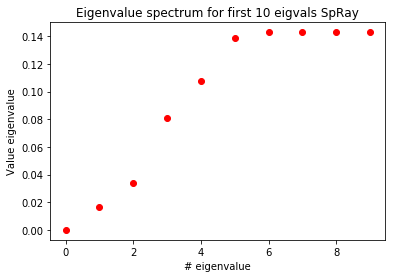

In [15]:
# Compute affinity matrix and plot the eigenvalues
affinity_matrix, laplacian, labels = spectral_clustering(data, n_clusters = 3, n_neighbors = 5)

In [16]:
def plot_embedding(X, y = subject_IDs, title=None, z_value = 45, brain_mask = nmm_mask):
    """Code adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py"""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure(figsize = (15, 15))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color = plt.cm.Set1(labels[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 3e-2:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            img = data[i].reshape(91, 109, 91)
            img[nmm_mask==0]=np.nan
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(img[10:81, 10:99, z_value].T, cmap=plt.cm.binary),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
    if save_fig is True: 
        fig.savefig('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/t_sne_embedding_AD_HC_3_classes.pdf')

In [17]:
# Compute t-sne embedding 
data_tsne = deepcopy(data)

print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, random_state=0, perplexity = 7, early_exaggeration = 6)
X_tsne = tsne.fit_transform(data_tsne)
print(X_tsne.shape)

Computing t-SNE embedding
(184, 2)


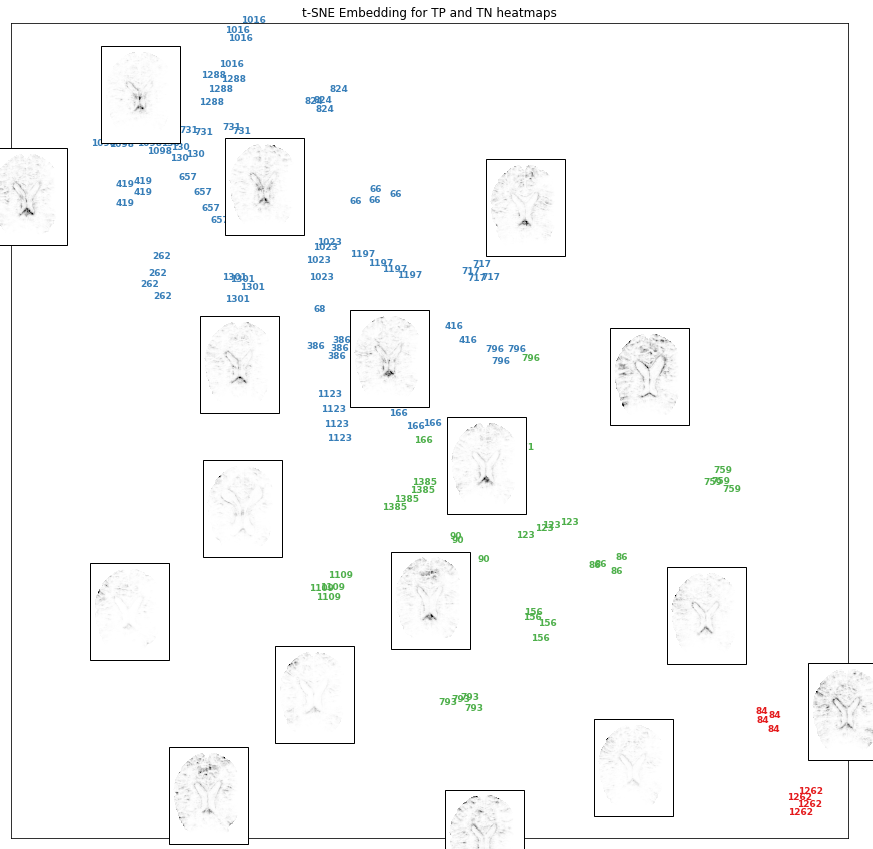

In [18]:
data_AD_tsne = X_tsne[mask_AD, :]
data_HC_tsne = X_tsne[mask_HC, :]

plot_embedding(X_tsne, title = 't-SNE Embedding for TP and TN heatmaps')

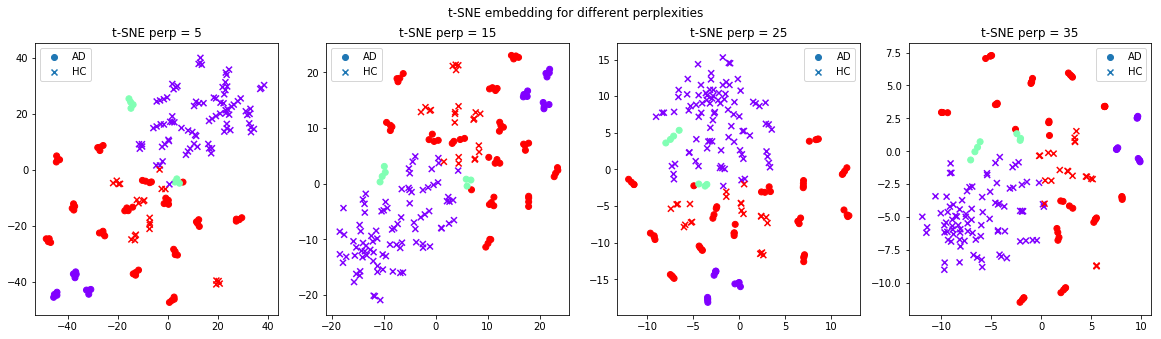

In [19]:
# Calculate the t-SNE embedding for different perplexities
perplexities = [5, 15, 25, 35]

fig, axs = plt.subplots(1, len(perplexities), figsize = (20, 5))

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, random_state=0, perplexity = perp, early_exaggeration = 6)
    X_tsne = tsne.fit_transform(data_tsne)
    
    data_AD_tsne = X_tsne[mask_AD, :]
    data_HC_tsne = X_tsne[mask_HC, :]

    axs[i].scatter(data_AD_tsne[:, 0], data_AD_tsne[:, 1], c = labels[mask_AD], cmap = 'rainbow', marker = 'o', label = 'AD')
    axs[i].scatter(data_HC_tsne[:, 0], data_HC_tsne[:, 1], c = labels[mask_HC], cmap = 'rainbow', marker = 'x', label = 'HC')
    axs[i].set_title('t-SNE perp = {}'.format(perp))
    axs[i].legend()
plt.suptitle('t-SNE embedding for different perplexities')
plt.show()

fig.savefig('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/t_sne_perp_AD_HC_3_classes.pdf')

In [20]:
shape = mean_maps_AD.shape

In [21]:
def plot_idv_brain(heat_map, brain_img, ref_scale, fig, ax, x_idx=slice(0, shape[0]), y_idx=slice(0, shape[1]),
                  z_idx=slice(0, shape[2]), vmin=90, vmax=99.5, set_nan=True, cmap=None, c=None):
    """Plot individual brains based on a reference value"""

    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(12, 12))
    
    img = deepcopy(heat_map)
    if set_nan:
        img[neuromorph_map==0]=np.nan
    if cmap is None:
        cmap = mcolors.LinearSegmentedColormap.from_list(name='alphared',
                                                  colors=[(1, 0, 0, 0),
                                                         "darkred", "red", "darkorange", "orange", "yellow"],
                                                  N=5000)
        
    if brain_img is not None:
#         print(brain_img[:, :, :].T.squeeze().shape)
        brain_img = brain_img.squeeze()
        ax.imshow(brain_img[x_idx, y_idx, z_idx].T, cmap="gray",
                 vmin=grey_vmin, vmax=grey_vmax, alpha=.45)

    vmin, vmax = np.percentile(ref_scale, vmin), np.percentile(ref_scale, vmax)
    im = ax.imshow(img[x_idx, y_idx, z_idx].T, cmap=cmap, 
               vmin=vmin, vmax=vmax, interpolation="gaussian")
  
    
    return fig, ax, im


In [22]:
# Set reference value
grey_vmin, grey_vmax = np.min(X_holdout), np.max(X_holdout)
save_fig = True

In [23]:
def plot_timepoints(df, images, AD_scores, clustering_labels, research_group, num_part = 5, title = '', save_fig = True):
    """Plot brain maps of a number of individual patients over all 4 time points including clustering label, 
    research group, and AD score"""
    df['ADscores'] = pd.Series(ad_scores)
    
    data_group = df[df['Research Group'] == research_group]
    data_group['Clustering label'] = pd.Series(labels)

    time_points = ['screen', 'month06', 'month12', 'month24']
    
    subject_IDs = list(data_group['SubjectID'].unique())
    subject_IDs_plotting = random.sample(subject_IDs, k = num_part)

    fig, axs = plt.subplots(len(subject_IDs_plotting), len(time_points), figsize = (20, 50))

    for i, subject in enumerate(subject_IDs_plotting): 
        subject_ID = str(subject)
        data_subject = data_group[data_group['SubjectID'] == subject_ID]
        for j, time_point in enumerate(time_points): 
            idx = int(data_subject[data_subject['session'] == time_point].index[0])

            AD_score = np.round(float(df['ADscores'].iloc[idx]), 4)
            
            fig, ax, im = plot_idv_brain(images[idx], X_holdout[idx], mean_maps_AD, fig = fig, ax = axs[i][j], z_idx = 80)
            axs[i][j].set_title('AD score {}, label = {}, class = {}'.format(AD_score, labels[idx], labels_classifier[idx]))
            axs[i][0].set_ylabel('{}'.format(subject))
            axs[num_part - 1][j].set_xlabel('{}'.format(time_point))
    plt.suptitle(title, y = 1.005)
    plt.tight_layout()
    plt.show()
    
    if save_fig is True:
        fig.savefig('/analysis/ritter/projects/AD/Budding_Spectral_Analysis/results/results_final/timepoints_{}.pdf'.format(research_group))

In [27]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
